In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [ ]:
graded_zs_df = pd.read_csv("results/trustworthy_zs_gpt-4.1-mini_graded.csv")
graded_zst_df = pd.read_csv("results/trustworthy_zst_gpt-4.1-mini_graded.csv")
graded_react_df = pd.read_csv("results/trustworthy_react_gpt-4.1-mini_graded.csv")
graded_planact_df = pd.read_csv("results/trustworthy_planact_gpt-4.1-mini_graded.csv")
graded_planreact_df = pd.read_csv("results/trustworthy_planreact_gpt-4.1-mini_graded.csv")

In [ ]:
plt.rcParams.update({
    "font.size": 18,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "axes.edgecolor": "#aaaaaa",
    "axes.linewidth": 0.8,
    "figure.facecolor": "white",
})

def plot_agent_stacked_bars(
    df: pd.DataFrame,
    agent_arch: str,
    trust_threshold: float = 0.8,
    figsize: tuple[float, float] = (8, 3),
    save_path: str = None
) -> None:
    """
    Plots 2 horizontal 100%-stacked bars: (1) original and (2) trust-filtered results for an agent.
    """

    def compute_percentages(df: pd.DataFrame, trust_filter: bool) -> pd.Series:
        finish_mask = df["action_name"] == "Finish"

        def classify(group: pd.DataFrame) -> str:
            finish = group[group["action_name"] == "Finish"]  # ← Fix applied here
            if finish.empty:
                return "halted"
            row = finish.iloc[-1]
            if trust_filter and (pd.isna(row["trust_score"]) or row["trust_score"] < trust_threshold):
                return "not attempted"
            return "correct" if row["llm_grade"] == "A" else "incorrect" if row["llm_grade"] == "B" else "not attempted"


        result = (
            df.sort_values(["task_id", "step"])
              .groupby("task_id")
              .apply(classify, include_groups=False)
        )
        return (
            result.value_counts(normalize=True)
                  .mul(100)
                  .reindex(["correct", "not attempted", "halted", "incorrect"], fill_value=0)
        )

    def draw_bar(ax: plt.Axes, pct: pd.Series) -> None:
        colours = {
            "correct": "#2ecc71",
            "not attempted": "#f1c40f",
            "halted": "#f1c40f",
            "incorrect": "#e74c3c",
        }
        hatches = {k: "//" if k == "halted" else "" for k in colours}
        left = 0
        for cat in ["correct", "not attempted", "halted", "incorrect"]:
            width = pct[cat]
            if width > 0:
                ax.barh(
                    0, width, left=left, height=0.3,
                    color=colours[cat],
                    edgecolor="white",
                    hatch=hatches[cat]
                )
                if width > 4:
                    ax.text(left + width / 2, 0, f"{width:.1f}%",
                            ha="center", va="center", weight="bold", fontsize=10)
                left += width
        ax.set_xlim(0, 100)
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)

    fig, axes = plt.subplots(nrows=2, figsize=figsize, sharex=True, gridspec_kw={"hspace": 0.1})
    fig.subplots_adjust(left=0.15, bottom=0.18, top=0.85)
    fig.suptitle(agent_arch, fontsize=16, y=0.98)

    for ax, (label, trust) in zip(axes, [("Original", False), (f"Trust score\n≥ {trust_threshold:.2f}", True)]):
        pct = compute_percentages(df, trust)
        draw_bar(ax, pct)
        ax.set_ylabel(label, rotation=0, labelpad=60, va="center", fontsize=12)

    axes[-1].set_xlabel("Percentage of tasks", labelpad=8)

    handles = [
        Patch(facecolor="#2ecc71", label="Correct"),
        Patch(facecolor="#f1c40f", label="Not attempted"),
        Patch(facecolor="#f1c40f", hatch="//", edgecolor="white", label="Halted"),
        Patch(facecolor="#e74c3c", label="Incorrect"),
    ]
    fig.legend(handles, [h.get_label() for h in handles],
               ncol=4, loc="lower center", frameon=False,
               fontsize=10, bbox_to_anchor=(0.5, -0.02))

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()


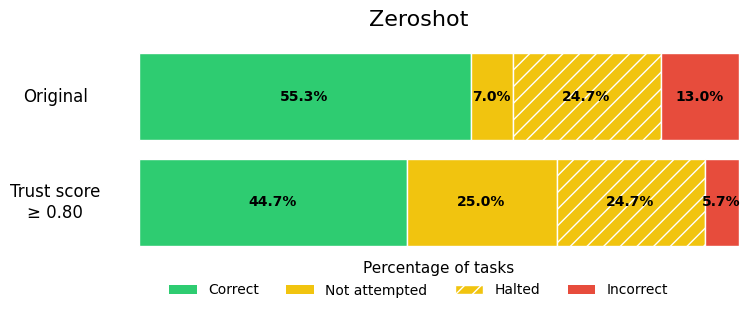

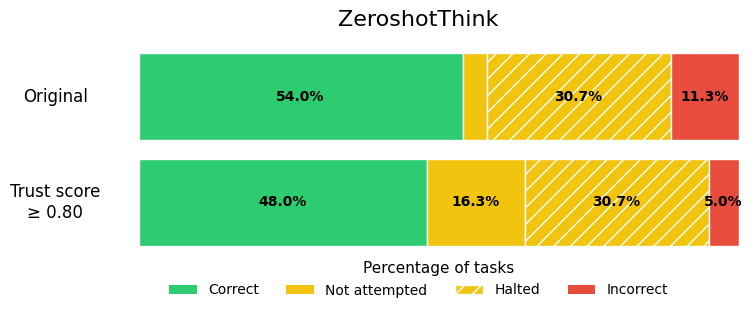

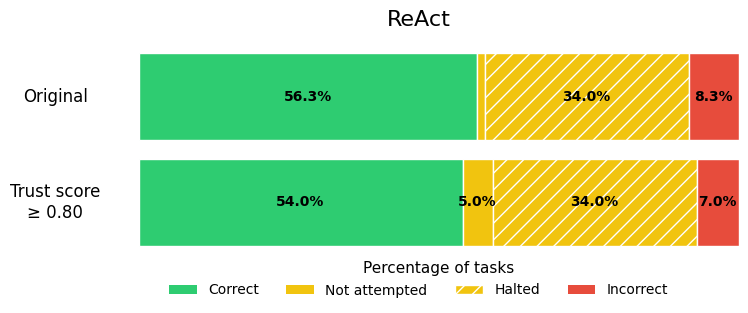

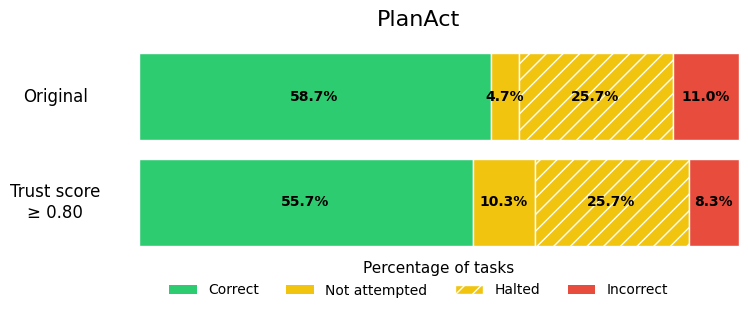

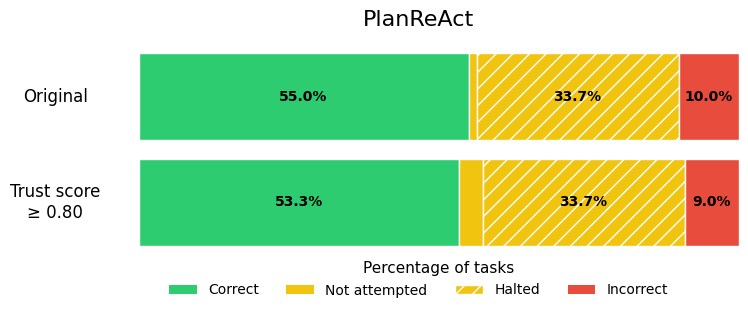

In [ ]:
plot_agent_stacked_bars(graded_zs_df, "Zeroshot", save_path="zs_results.png")
plot_agent_stacked_bars(graded_zst_df, "ZeroshotThink", save_path="zst_results.png")
plot_agent_stacked_bars(graded_react_df, "ReAct", save_path="react_results.png")
plot_agent_stacked_bars(graded_planact_df, "PlanAct", save_path="planact_results.png")
plot_agent_stacked_bars(graded_planreact_df, "PlanReAct", save_path="planreact_results.png")

In [ ]:
np.random.seed(42)  # Set random seed for reproducibility

def compute_incorrect_rate(df: pd.DataFrame,
                           filter_col: str = None,
                           threshold: float = None) -> float:
    """
    Returns the % of tasks classified as 'incorrect' out of *all* tasks,
    after applying an optional filter on the finish-row score—but only
    dropping among tasks that were actually attempted (A or B).
    """
    total_tasks = df["task_id"].nunique()
    finish = (
        df[df["action_name"] == "Finish"]
          .groupby("task_id")
          .last()
    )

    # identify the attempted tasks
    attempted = finish[finish["llm_grade"].isin(["A", "B"])]

    # figure out which of those attempted get “dropped” by this filter
    if filter_col is not None:
        drops = attempted[
            attempted[filter_col].isna() |
            (attempted[filter_col] < threshold)
        ].index
    else:
        drops = pd.Index([])

    # remove only those dropped tasks from the finish set
    kept = finish.drop(drops)

    # count incorrect among kept
    n_incorrect = (kept["llm_grade"] == "B").sum()

    # denominator is still all tasks (including halted/non‐attempted)
    return 100 * n_incorrect / total_tasks


def summary_table_list(
    agent_data: list[tuple[str, pd.DataFrame]],
    trust_threshold: float = 0.8
) -> pd.DataFrame:
    rows = []
    for agent_name, df in agent_data:
        df = df.copy()
        # 1) assign a random score to every row
        df["random_score"] = np.random.rand(len(df))

        # 2) pull out just the finish rows (one per task)
        finish = (
            df[df["action_name"] == "Finish"]
              .groupby("task_id")
              .last()
        )
        # 3) restrict to attempted only
        attempted = finish[finish["llm_grade"].isin(["A", "B"])]

        # 4) compute fraction of attempted that TLM would drop
        tlm_drops = attempted[
            attempted["trust_score"].isna() |
            (attempted["trust_score"] < trust_threshold)
        ].shape[0]
        prop = tlm_drops / len(attempted)

        # 5) find matching random score threshold among attempted
        rand_threshold = np.quantile(attempted["random_score"].values, prop)

        # 6) compute the three incorrect‐rates
        orig_rate = compute_incorrect_rate(df)
        rand_rate = compute_incorrect_rate(df, "random_score", rand_threshold)
        tlm_rate  = compute_incorrect_rate(df, "trust_score", trust_threshold)

        rows.append({
            "Agent Type": agent_name,
            "Incorrect Rate (Original)":       f"{orig_rate:.1f}%",
            "Incorrect Rate (Random Filter)":  f"{rand_rate:.1f}%",
            "Incorrect Rate (TLM Filter)":     f"{tlm_rate:.1f}%"
        })

    return pd.DataFrame(rows)


# ——— Usage ———
agent_data = [
    ("zs",        graded_zs_df),
    ("zst",       graded_zst_df),
    ("react",     graded_react_df),
    ("planact",   graded_planact_df),
    ("planreact", graded_planreact_df),
]

table = summary_table_list(agent_data, trust_threshold=0.8)
table


,Agent Type,Incorrect Rate (Original),Incorrect Rate (Random Filter),Incorrect Rate (TLM Filter)
0,zs,13.0%,9.0%,5.7%
1,zst,11.3%,8.7%,5.0%
2,react,8.3%,8.0%,7.0%
3,planact,11.0%,10.0%,8.3%
4,planreact,10.0%,10.0%,9.0%
